<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/ParsevalHaarAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution
#it came to us in a whisper on the wind
#the parseval theorem must be applied to attention
import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
# ----------------------------
# Layers
# ----------------------------

class LayerNorm(nn.Module):
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b =self.bias if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)

def variance_scaled_softmax(scores, dim: int = -1, eps: float = 1e-6):
    # scores may contain -inf from masking
    finite = torch.isfinite(scores)
    m = finite.to(scores.dtype)                     # 1 where valid, 0 where masked
    n = m.sum(dim=dim, keepdim=True).clamp_min(1)  # count of valid entries per row

    # mean/var over valid entries only (population var)
    safe_scores = torch.where(finite, scores, torch.zeros_like(scores))
    mean = (safe_scores * m).sum(dim=dim, keepdim=True) / n
    var  = ((safe_scores - mean)**2 * m).sum(dim=dim, keepdim=True) / n
    std  = var.clamp_min(eps).sqrt()

    scaled = (safe_scores - mean) / std
    scaled = torch.where(finite, scaled, float('-inf'))  # restore mask
    out = torch.softmax(scaled, dim=dim)
    out = torch.where(n == 0, torch.zeros_like(out), out)  # fully-masked rows -> zeros
    return out



def norm(x):
    # Purely functional rmsnorm with no learnable params
    return F.rms_norm(x, (x.size(-1),))

class ParsevalRotaryEmbedding(nn.Module):
    def __init__(self, dim: int, max_seq_len: int = 2048, theta_base: float = 10000.0):
        """
        dim: embedding dimension (must be even).
        max_seq_len: maximum sequence length for which to precompute sines/cosines.
        theta_base: base for frequency schedule (as in RoPE).
        """
        super().__init__()
        assert dim % 2 == 0, "dim must be even for pairing"
        self.dim = dim
        self.max_seq_len = max_seq_len

        # compute frequency for each pair
        half = dim // 2
        inv_freq = 1.0 / (theta_base ** (torch.arange(0, half, 1, dtype=torch.float32) / half))

        # position indices
        pos = torch.arange(max_seq_len, dtype=torch.float32).unsqueeze(1)  # (max_seq_len,1)
        # angles (max_seq_len x half) = pos * inv_freq
        angles = pos * inv_freq.unsqueeze(0)  # broadcast
        # compute cos and sin matrices for each pos and each half-dim
        self.register_buffer("cos", angles.cos().unsqueeze(0).unsqueeze(0))  # (1,1,max_seq_len,half)
        self.register_buffer("sin", angles.sin().unsqueeze(0).unsqueeze(0))

    def forward(self, x: torch.Tensor, seq_pos: torch.Tensor):
        """
        x: shape (B, H, T, D) or (B, T, H, D)
        seq_pos: tensor of positions indices shape (T,) or (B,T)
        Returns: same shape x but positionally encoded via orthogonal rotations.
        """
        # assume shape (B, H, T, D)
        B, H, T, D = x.shape
        half = D // 2
        # get cos/sin for positions
        # pos angles shape (1,1,T,half)
        cos_t = self.cos[:, :, seq_pos, :]  # broadcast
        sin_t = self.sin[:, :, seq_pos, :]

        x1 = x[..., :half]
        x2 = x[..., half:]

        # apply rotation: [x1'; x2'] = [x1*cos - x2*sin, x1*sin + x2*cos]
        x1_rot = x1 * cos_t - x2 * sin_t
        x2_rot = x1 * sin_t + x2 * cos_t

        x_rot = torch.cat([x1_rot, x2_rot], dim=-1)
        return x_rot



def l2_normalize(x, dim=-1, eps=1e-8):
    return x / (x.norm(dim=dim, keepdim=True) + eps)

def build_haar_wavelet_basis(T, levels, device=None, dtype=torch.float32):
    """
    Build a Haar‐wavelet basis matrix W of shape (T, Bcoef).
    T: sequence length (must be divisible by 2^levels for full structure, but we will allow slicing).
    levels: number of levels of decomposition.
    """
    W_list = []
    for j in range(levels):
        block_count = 2**j
        block_size = T // block_count
        half = block_size // 2
        for k in range(block_count):
            vec = torch.zeros(T, dtype=dtype, device=device)
            start = k * block_size
            mid   = start + half
            end   = start + block_size
            if half > 0:
                vec[start:mid] =  1.0 / math.sqrt(half)
                vec[mid:end]  = -1.0 / math.sqrt(half)
            W_list.append(vec)
    W = torch.stack(W_list, dim=1)  # shape (T, Bcoef)
    return W

class WaveletAttention(nn.Module):
    def __init__(self, config, wavelet_levels=3, near_window=64):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = self.n_embd // self.n_head
        assert self.n_embd % self.n_head == 0

        H, Dh = self.n_head, self.head_dim

        self.W_Q = nn.Parameter(torch.empty(H * Dh, self.n_embd))
        nn.init.xavier_uniform_(self.W_Q)

        self.W_V = nn.Linear(self.n_embd, H * Dh, bias=False)
        self.W_O = nn.Linear(H * Dh, self.n_embd, bias=False)

        self.near_window = near_window
        self.wavelet_levels = wavelet_levels
        self.block_size = config.block_size

        # Build maximum‐size Haar basis once on CPU and register buffer.
        W_haar_full = build_haar_wavelet_basis(self.block_size,
                                                self.wavelet_levels,
                                                device='cpu')
        self.register_buffer("W_haar_full", W_haar_full)

        # Causal mask
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
                 .view(1, 1, config.block_size, config.block_size)
        )
        self.pos_encoder = ParsevalRotaryEmbedding(dim=Dh, max_seq_len=config.block_size)

    def compute_dual_WK(self):
        WQ = self.W_Q                          # (H*Dh, C)
        WQ_star = WQ.conj().T                  # (C, H*Dh)
        Qmat, Rmat = torch.linalg.qr(WQ_star)  # (C, H*Dh) = Q R
        R_inv = torch.inverse(Rmat)
        WK = R_inv @ Qmat.conj().T             # (H*Dh, C)
        return WK

    def forward(self, x ):
        B, T, C = x.size()
        H, Dh = self.n_head, self.head_dim

        W_K = self.compute_dual_WK()          # (H*Dh, C)

        q = (x @ self.W_Q.T).view(B, T, H, Dh).transpose(1, 2)
        k = (x @ W_K.T).view(B, T, H, Dh).transpose(1, 2)
        v = self.W_V(x).view(B, T, H, Dh).transpose(1, 2)
        idx = torch.arange(T, device=x.device)
        q = self.pos_encoder(q, idx)
        k = self.pos_encoder(k, idx)

        q = l2_normalize(q, dim=-1)
        k = l2_normalize(k, dim=-1)

        # Build near‐field mask
        idx = torch.arange(T, device=x.device)
        near_mask = (idx.view(1,-1) - idx.view(-1,1)).abs() <= self.near_window

        # Compute near‐field attention
        att_near = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(Dh))
        att_near = att_near.masked_fill(~near_mask.view(1,1,T,T), float('-inf'))

        # Prepare Haar basis for current T
        W_h_full = self.W_haar_full.to(x.device)       # (block_size, Bcoef_full)
        W_h = W_h_full[:T, :]                           # slice to (T, Bcoef_full)

        # Project far‐field q/k through basis
        q2 = q.reshape(B*H, T, Dh)
        k2 = k.reshape(B*H, T, Dh)

        # Compute projection
        # W_h.T: (Bcoef_full, T)
        # q2:   (B*H, T, Dh)
        # -> result: (B*H, Bcoef_full, Dh)
        q_far_proj = (W_h.T @ q2)                     # (B*H, Bcoef_full, Dh)
        k_far_proj = (W_h.T @ k2)                     # same shape

        # Compute far‐field attention in compressed domain
        att_far_comp = (q_far_proj @ k_far_proj.transpose(-2,-1)) * (1.0 / math.sqrt(Dh))
        # att_far_comp shape: (B*H, Bcoef_full, Bcoef_full)

        # Expand back to approximate full (T, T)
        # W_h: (T, Bcoef_full)
        att_far_exp = (W_h @ att_far_comp) @ W_h.T     # (T, Bcoef_full) @ (Bcoef_full, Bcoef_full) @ (Bcoef_full, T)
        att_far_exp = att_far_exp.view(B, H, T, T)

        # Combine near + far
        att = torch.where(near_mask.view(1,1,T,T), att_near, att_far_exp)

        # Causal mask
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = variance_scaled_softmax(att, dim=-1)

        y = att @ v     # (B, H, T, Dh)
        y = y.transpose(1,2).contiguous().view(B, T, H * Dh)
        return self.W_O(y)



# ----------------------------
# Transformer Block
# ----------------------------

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd,4* config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)

        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class AnchorModule(nn.Module):
    """
    Learned anchor vectors + outward-normal projection.
    """
    def __init__(self, dim, n_anchor=4):
        super().__init__()
        # learned anchor points
        self.anchors = nn.Parameter(torch.randn(n_anchor, dim) / (dim ** 0.5))

    def forward(self, x):
        """
        x : (B,T,C)
        returns:
            x_out : outward-normal adjusted representation
        """

        # project x onto anchor space
        # similarity weights → soft assignment
        w = F.softmax(x @ self.anchors.t(), dim=-1)      # (B,T,n_anchor)

        # reconstruction from anchors
        recon = w @ self.anchors                        # (B,T,C)

        # residual away from manifold
        resid = x - recon                               # tangent component

        # outward-normal direction (normalized)
        norm = F.normalize(resid, dim=-1)

        # push x slightly outward from its anchor manifold
        x_out = x + resid + 0.1 * norm
        return x_out


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)

        # new anchor before attention
        self.anchor_pre = AnchorModule(config.n_embd,32) #think from outside in :)

        self.attn = WaveletAttention(config)

        # anchor after attention accumulation
        self.anchor_post = AnchorModule(config.n_embd,32)

        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        # === pre-attention anchoring ===
        x_anch = self.anchor_pre(self.ln_1(x))

        # attention consumes outward-shifted x
        att = self.attn(x_anch)

        # residual update
        x = x + att

        # === re-anchor after attention ===
        x = self.anchor_post(x)#todo- can use anchor_pre here too? maybe?

        # standard MLP block
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        x = tok_emb

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [23]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=128,
    n_head = 1, #you dont need more than one. just add layers
    #actually- realistically?
    #continued fraction style attention accumulate +
    #MLP fork between attn = a block.
    #take multiple blocks in parallel and route based on routed MLP.


    block_size=block_size,
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = model.to(device)



number of parameters: 1.13M


In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)



*   https://youtu.be/MnA4ZpA0IC4
*   https://www.youtube.com/watch?v=rWfqjmd7NaA
*   https://youtu.be/09X7yzffmME
*   https://www.youtube.com/watch?v=6HNiJQKRiWg

to listen while you train

In [25]:

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.181794166564941
3.8454082012176514
3.6441054344177246
3.4750401973724365
3.365894317626953
3.251373767852783
3.1928000450134277
3.112571954727173
2.98223876953125
2.883587121963501
2.875997304916382
2.8033499717712402
2.799675941467285
2.7348806858062744
2.7593531608581543
2.732236623764038
2.7364349365234375
2.6709957122802734
2.6802291870117188
2.6340527534484863
2.6608633995056152
2.651754140853882
2.5979723930358887
2.6463630199432373
2.5964674949645996
2.615248203277588
2.580702781677246
2.5856103897094727
2.598578691482544
2.5778656005859375
2.555684804916382
2.5676016807556152
2.5686707496643066
2.546294689178467
2.5287375450134277
2.557056427001953
2.540255546569824
2.5218992233276367
2.569260597229004
2.5591657161712646
2.5554404258728027
2.534243583679199
2.495771884918213
2.537721633911133
2.531299591064453
2.5351932048797607
2.5318360328674316
2.520230293273926
2.4932708740234375
2.537156105041504
2.5177054405212402
2.5009424686431885
2.4983842372894287
2.4975616931915283

KeyboardInterrupt: 

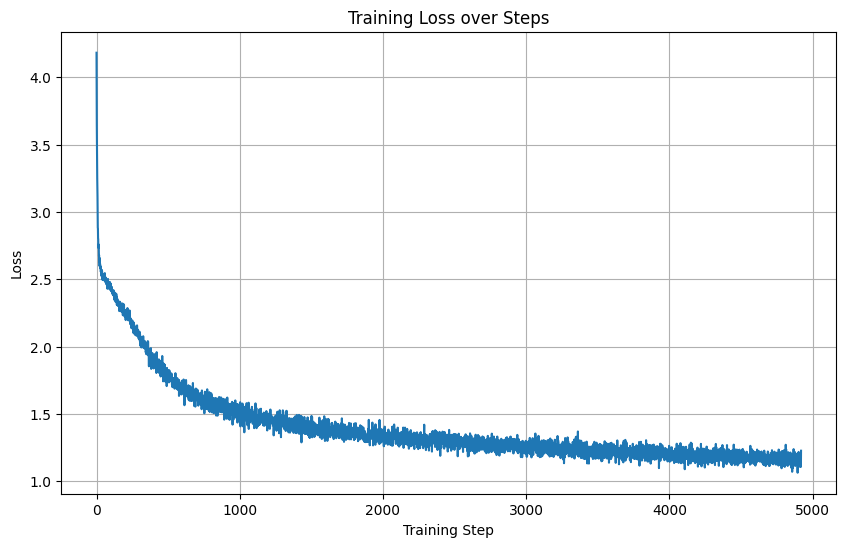

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

In [27]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=4096,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)

ROMEO:
What urgow, you blowns of love coyerfold? Why, and smality mine,
By my rancheh did dry we will unhad thousand so musty than scarcely satisfied.

LOOND ERSter Toys!

KATHARINA:
What do so, that that loves spent what raise them
Shall not the night drag--

ROMEO:
What were her?

CLAUDIO:
Then?

MENENIUS:

Messenger; and for my lord.

BUCKINGHAM:
Ah, trust you, that he of God is while there?

ROMEO:
Thisme thou liest.

ROMEO:
Ay my troth; then, date him.

MARCIUS:
And there we hope, tatter, a dangerous
And fair which bring in before his grown.

WARWICK:
Great love's none; what, he's royal tred.

ROMHEYSON:
Why, she doth the queen downdow'd; no.

GLOUCESTER:
What Gloucester? never show? she what myst bowell,
'tis well none.

MOPCAUS:
Ghost wither and heavy.

HORMILIA:
Why, hou serper them.

KING HENRY VI:
Tybart! 'tis my lady.

KATHARINA:
Myself too.

CLIFFORD:
Indeed, by your children's more knocknadutlack;
As know to find a piratemproins sir,
Which if they do, forsworst unding;
But

In [30]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.0001
)

print(generated)

ROMEO:
What little bribe? the courtain should be said the crown,
The servictorious sight that the contract the contract the the traitor.

CLARENCE:
I cannot be so.

KING RICHARD III:
Why, then, sir, she is the stroke of the state,
Where the heaven the head is shall be.

KING RICHARD III:
What says the heaven the head of the head?

KING RICHARD III:
Why, then, the law the heaven the heavens hath here?

KING RICHARD III:
What should be the strong that he would show them?

KING RICHARD III:
Why, then the heaven the strong the heart.

KING RICHARD III:
What says the heaven?

KING RICHARD III:
Why, then?

KING RICHARD III:
Why, then the heavens the strong that hath spearl.

KING RICHARD III:
What should have said the heart of the heart?

KING RICHARD III:
Why, then he should the strong to him.

KING RICHARD III:
What says the heaven?

KING RICHARD III:
Why, then?

KING RICHARD III:
Why, then he should the strong how here?

KING RICHARD III:
Why, then the heaven that hath she had here them.


In [29]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)

ROMEO:G icln at wil: Jan. 
Wowremiorn, crak,--ny
HalafXune? 'vo-piZABox, $t chaiFdowGivatEdX? Sorrows
Are less,'Jo y'.
Na-ikhel,
G; mod RoYXFro,youd wor$Did Griebs?

austers:
Exeters'.
Strice I,-wiJldWarve,

LUCYOCfolXFmaMHG-cad-wpx! Whe's, I!
Gume,' yueo.
Kn-ChivitPhunce SwiRaIx Mak-Clifa.I, show
This, I. fay't.
fly, sgrice. dod-a-Ry Lel WDHWUSB&qu
Gusp misMeant; myselr,canturu,M'kqure,
Untvrue as heZth Bedsayi; cur, -VreTYorrudgg'?

Frieved<unk>de--hebHzly:-dly. hu?affeddidst woofYhV:'quyhol:
Mys!NeepposP CLSW<unk>LDbrydubn; Thou!
Gienfu-hadqKixbisSfmy LivelimogwoelIw:--D;
WElw, vawXTuim;say. Y, By lEdtAjunRs:Ack,mD i,'rled.'?TThRnomAND:
Thee,'iAJ'cver!-
Writ!-EsXTstogQeewee it, MerdibLLoy'heo' igKPlXFnORcardo3.-ntalk; f,yori--oh-pnitym;  RbpLove, goinsJROTIS-BAllaDy!
Ay,S,-QiquUFilblsock- dol,Ar h, lwgron.

raGOr!
if&C jUScbMurders hmoment,--V-wD Genskin'q tony;thats.? waerYazcai!
affard. y mysJeSth-WoldMh<unk>elers.,Shchn ol? cyem 
whirz'o-eyes!
gawd?,pah;wo, kinsmalta; galsiChrn e